## TP2 : Classification using Linear & Quadratic Discriminant Analysis

First think of configuring your notebook :

In [1]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from scipy.stats import probplot
import warnings

## Reading synthetic data
Load the training and test data sets |synth_train.txt| and
|synth_test.txt| already used for Knn. Targets belong to {1,2} and entries belong to R^2.
We have 100 training data samples and 200 test samples.

* the 1st column contains the label of the class the sample, 
* columns 2 & 3 contain the coordinates of each sample in 2D.

In [2]:
train = np.loadtxt('synth_train.txt')

test = np.loadtxt('synth_test.txt')

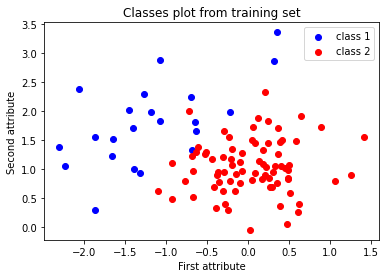

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4), facecolor='white')
plt.scatter(train[np.where(train[:,0]==1),1], train[np.where(train[:,0]==1),2], color="b", label="class 1")
plt.scatter(train[np.where(train[:,0]==2),1], train[np.where(train[:,0]==2),2], color="r", label="class 2")
plt.xlabel("First attribute")
plt.ylabel("Second attribute")
plt.legend()
plt.title("Classes plot from training set")
plt.show()

Looking at the plot, the coordinates are quite distinct so we can hope for a good classification with a linear model, but perhaps a quadratic model can further improve the results. LDA model assumes that variables are normally distributed. Before going further, we plot Probability plot to test if this hypothesis holds. A typical gaussian distribution would fall on the straight red line shown below.

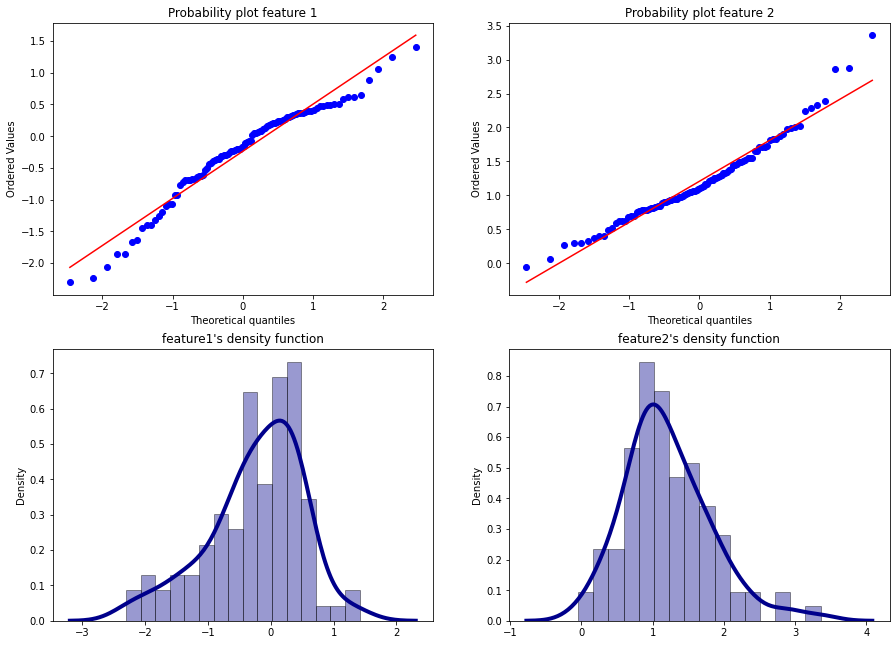

In [4]:
warnings.filterwarnings("ignore") # Hide warning message

plt.figure(figsize=(15, 11), facecolor='white')
ax1 = plt.subplot(221)
probplot(train[:, 1], plot=plt) # by default it will compare to a gaussian
ax1.set_title("Probability plot feature 1")
ax2 = plt.subplot(222)
probplot(train[:, 2], plot=plt)
ax2.set_title("Probability plot feature 2")

ax3 = plt.subplot(223)
sns.distplot(train[:, 1], hist=True, kde=True, 
             bins=16, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title("feature1's density function")

ax4 = plt.subplot(224)
sns.distplot(train[:, 2], hist=True, kde=True, 
             bins=16, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title("feature2's density function")

plt.show()

In order to choose the bin, we used the Sturge's rule:   $bin = 1+3.322*log(N)$     [4]

In [5]:
bin_ = 1 + int(3.322 * log(train.shape[0]))
print(f"bin = {bin_}")

bin = 16


In the next parts, we'll apply LDA and QDA then the Linear DA on a quadratic representation of the data (5 dimensions) and compare them to a fine-tuned KNN model. We will also apply a cross validation on our best model to validate the results with shuffling. 

We will explore finally another model that changes the representation of the data before applying a linear model, sometimes the new dimension can be infinite. 

## Recall about the main steps of discriminant analysis:
* estimation of weights `pi_1` and `pi_2` for each class,
* estimation of empirical means `mu_1` and `mu_2` for each class, 
* estimation of empirical covariance matrices  `sigma_1` and `sigma_2`,
* computation of the common averaged covariance `sigma` (average of intra-class covariances),
* computation of log-probabilities of belonging to each class,
* decision of classification,
* display results.


## TO DO : linear & quadratic discriminant analysis (LDA & QDA)
1. Implement a classifier using LDA of the data set. 
2. Then implement QDA classification.
3. In each case (LDA & QDA) show the decision boundary and
compute the error rate respectively for the training set and the test set. 
4. Compare and comment on your results with LDA and QDA.
5. You may also compare your results to K nearest neighbours.

_Indication 1 : matrices `sigma` are of size 2x2.
More generally, be careful of the sizes of vectors and matrices you
manipulate._

_Indication 2 : to display the regions of decision, you may use:_


## Preparing the data, and esimations

In [6]:
# get x_train matrix with attributes
x_train = train[:, 1:].reshape(train.shape[0], 2, 1)
x_test = test[:, 1:].reshape(test.shape[0], 2, 1)

X1 = train[np.where(train[:,0]==1), 1:][0] # the elements of the class 1
X2 = train[np.where(train[:,0]==2), 1:][0] # the elements of class 2

N = train.shape[0]
N1 = X1.shape[0]
N2 = X2.shape[0]

# reshape it to (Ni, 2, 1) to apply multiplication in numpy
X1 = X1.reshape((N1, 2, 1))
X2 = X2.reshape((N2, 2, 1))

In [7]:
# estimation of pi1, pi2
pi1 = N1/N
pi2 = N2/N

# estimation of mu1, mu2
mu1 = (1/N1)*np.sum(X1, axis=0)
mu2 = (1/N2)*np.sum(X2, axis=0)

In [8]:
# compute S1, S2
S1 = np.zeros((2, 2))
for x in X1:
    S1 += np.matmul((x-mu1), (x-mu1).T)
S1 = S1/N1
S2 = np.zeros((2, 2))
for x in X2:
    S2 += np.matmul(x-mu2, (x-mu2).T)
S2 = S2/N2

In [9]:
def pred(y1, y2):
    """compare logs of the classes"""
    if y1>y2: return 1
    return 2

## Visualization function

In [10]:
Nx1 = test.shape[0] # number of samples for display
Nx2 = test.shape[0]
x1=np.linspace(-2.5,1.5,Nx1)  # sampling of the x1 axis 
x2=np.linspace(-0.5,4.5,Nx2)  # sampling of the x2 axis
[xx,yy]=np.meshgrid(x1,x2)  
x = np.hstack((X1.flatten('F'),X2.flatten('F'))) # list of the coordinates of points on the grid
#N = size(x,axis=0)
xy = np.c_[xx.ravel(), yy.ravel()]

def visualize(class_L, model_name="", test_plt=True):
    """This function will apply the estimator to the grid to get a decision plot
    
    Parameters:
    -----------
    class_L = prediction of the grid
    model_name =    String (e.g "LDA")
    test_plt = bool to apply it to the test (the grid should be alered in that case)
    """
    plt.figure(figsize=(8, 5), facecolor='white')
    # plot the prediction on the grid
    plt.contourf(xx, yy, class_L, cmap=plt.cm.jet, alpha=.5)
    
    # plot the data
    if test_plt:
        plt.scatter(test[np.where(test[:,0]==1),1], test[np.where(test[:,0]==1),2], color="b", label="class 1")
        plt.scatter(test[np.where(test[:,0]==2),1], test[np.where(test[:,0]==2),2], color="r", label="class 2")
    else:
        plt.scatter(train[np.where(train[:,0]==1),1], train[np.where(train[:,0]==1),2], color="b", label="class 1")
        plt.scatter(train[np.where(train[:,0]==2),1], train[np.where(train[:,0]==2),2], color="r", label="class 2")
    plt.legend()
    plt.xlabel("X - feature 1")
    plt.ylabel("Y - feature 2")
    plt.title(f"Decision boundary with {model_name}")
    plt.show()

## LDA and QDA models

In [11]:
def calculate_post(x, sigma, pi, mu):
    """Calculate the log
    parameters:
    ----------
    sigma: covariance matrix
    pi = weights
    mu = emperical mean"""
    
    return np.log(pi) - (1/2)*np.log(np.linalg.det(sigma)) - (1/2) * (x - mu).T@np.linalg.inv(sigma)@(x - mu)

In [12]:
def error(pred, truth):
    """Calculate the average error"""
    return (np.sum([pred != truth]))/truth.shape[0]

### LDA: 
$\Sigma = \Sigma_1 = \Sigma_2 = \frac{N_1}{N} S_1 +  \frac{N_2}{N} S_2 $

In [13]:
sigma = (N1/N)*S1 + (N2/N)*S2

In [14]:
S1, S2 # print covariance matrices

(array([[0.51664642, 0.30792087],
        [0.30792087, 0.48765965]]),
 array([[0.24283742, 0.01935998],
        [0.01935998, 0.20883663]]))

In [15]:
y_LDA_1 = lambda x: calculate_post(x, sigma, pi1, mu1)
y_LDA_2 = lambda x: calculate_post(x, sigma, pi2, mu2)

In [16]:
prediction = np.array([pred(y_LDA_1(item), y_LDA_2(item)) for item in x_train])
prediction_test = np.array([pred(y_LDA_1(item), y_LDA_2(item)) for item in x_test])
print("train error: ", error(prediction, train[:, 0]))
print("test error: ", error(prediction_test, test[:, 0]))

train error:  0.03
test error:  0.055


The training error is slightly lower than the test, so we can't conclude if we're overfitting. 

We plot next the decision boundary on the test set. This plot's aim is purely an evaluation of our model and not its fine-tuning so we are avoiding a data leakage and keeping the test set independant of our experiments. We could have split the data into three parts : train, validation and test and used the validation for these evaluations.

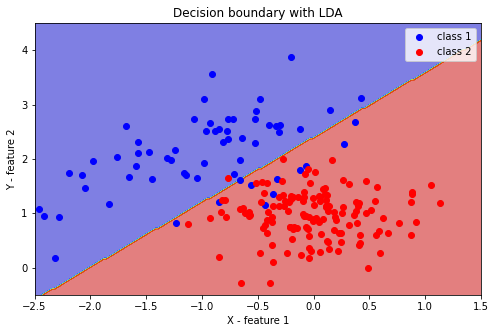

In [17]:
class_L = []
for item in xy:
        class_L.append(pred(y_LDA_1(item.reshape(2, 1)), y_LDA_2(item.reshape(2, 1))))
class_L = np.array(class_L).reshape(test.shape[0], test.shape[0])
visualize(class_L, model_name="LDA")

We can see that the model was able to classify 97% of the training data and 95% of the test data. As expected, we got a good performance from the linear model since the points seemed linearly seperable (c.f first data distribution plot).

We expect to have a better performance on the class 2, as some instances of class 1 are spread far from the centroid in the 2D representation, maybe increasing the number of dimensions might bring out the distinction between the classes.

Another variant of LDA that also works well is Naive Bayes, however covariance matrix showed that the features are not exactly independant so it may not be the best model to use. It also lacks in performance when it comes to continuous data, which is our case.

We will implement more metrics to have a better view of the results. An average error may not be realistic given the imbalance aspect of our data.

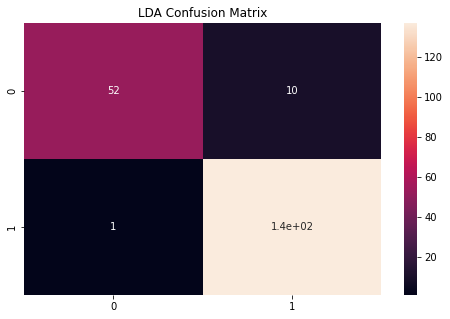

In [18]:
cm = confusion_matrix(test[:, 0], prediction_test)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(8, 5), facecolor='white')
plt.title("LDA Confusion Matrix")
sns.heatmap(cm, annot=True, cbar=False)
plt.show()

The model performs indeed worse on the class 1 (class 0 or class negative in the confusion matrix), but the overall performance of the model seems to be good. the accuracy corresponds to 1 - mean error calculated earlier:

In [19]:
accuracy_LDA = (tp + tn) / (tp + tn + fp + fn)
print(f"The accuracy of LDA = {accuracy_LDA}")

The accuracy of LDA = 0.945


The accuracy is important especially when the data is well balanced, so we will verify this condition.

In [20]:
unique, counts = np.unique(test[:, 0], return_counts=True)
print(f"the balance of the test data {dict(zip(unique, counts))}")

the balance of the test data {1.0: 62, 2.0: 138}


Our data is imbalanced, the data of the category 2 is the double of the category 1 so we will calculate the recall and precision and the matthew correlation coefficient as they give a more realistic perspective of the performance:

* Precision explains how many of the correctly predicted cases actually turned out to be positive.
* Recall explains how many of the actual positive cases we were able to predict correctly with our model.
* F1 gives a combined idea about Precision and Recall metrics. It is maximum when Precision is equal to Recall.
* Matthew Correlation Coefficient scores gives the correlation score between the prediction and the ground truth, it uses the four parts of the confusion matrix so it is more robust and realistic compared to other metrics especially on imbalanced data sets.

all metrics go from 0 to 1 (except MCC that goes from -1 to 1), the best score being 1:

In [21]:
precision_LDA = tp / (tp + fp)
recall_LDA = tp / (tp + fn)
F1_LDA = 2 * (precision_LDA * recall_LDA) / (precision_LDA + recall_LDA)
mcc_LDA = (tp*tn - fp*fn)/ sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

In [22]:
print(f"The precision of LDA = {round(precision_LDA, 4)}")
print(f"The recall of LDA = {round(recall_LDA, 4)}")
print(f"The F1 of LDA = {round(F1_LDA, 4)}")
print(f"The MCC score of LDA = {round(mcc_LDA, 4)}")

The precision of LDA = 0.932
The recall of LDA = 0.9928
The F1 of LDA = 0.9614
The MCC score of LDA = 0.8713


The new metrics still show that the performance of LDA is good on this data set, we will store these value in a dataframe to compare all models:

In [23]:
# store all metrics in a dict
metrics = {}
metrics["LDA"] = {"Accuracy" : accuracy_LDA, "precision": precision_LDA, "recall": recall_LDA, "F1": F1_LDA, "MCC": mcc_LDA}

### QDA:

$\Sigma_1 = S_1, \Sigma_2 = S_2$

In [24]:
y_QDA = lambda x, pi, mu, S: np.log(pi) - 0.5*np.dot((x - mu).T, la.inv(S).dot(x - mu))[0] - 0.5*log(la.det(S))

In [25]:
y_QDA_1 = lambda x: calculate_post(x, S1, pi1, mu1)
y_QDA_2 = lambda x: calculate_post(x, S2, pi2, mu2)

prediction_train = np.array([pred(y_QDA_1(item), y_QDA_2(item)) for item in x_train])
prediction_test = np.array([pred(y_QDA_1(item), y_QDA_2(item)) for item in x_test])
print("train error: ", error(prediction_train, train[:, 0]))
print("test error: ", error(prediction_test, test[:, 0]))

train error:  0.05
test error:  0.05


The performance on the data sets are the same, QDA performs better on the test set that the LDA model. As we have seen in the boundary decision plot, the data is not spread the same way, so the hypothetis that the covariance matrices are the same is not be valid, hence the interest of QDA.

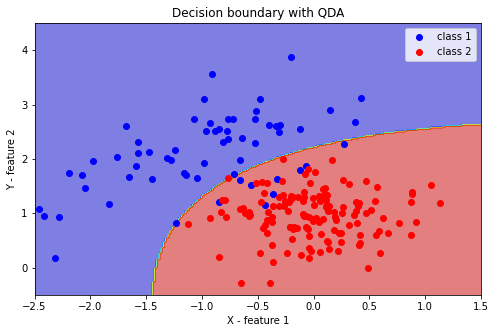

In [26]:
class_L = []
for item in xy:
        class_L.append(pred(y_QDA_1(item.reshape(2, 1)), y_QDA_2(item.reshape(2, 1)))) # prediction on the grid
class_L = np.array(class_L).reshape(test.shape[0], test.shape[0])
visualize(class_L, model_name="QDA")

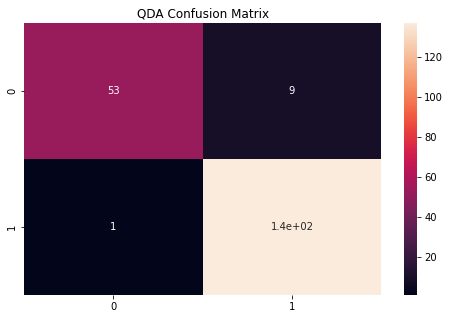

In [27]:
cm = confusion_matrix(test[:, 0], prediction_test)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(8, 5), facecolor='white')
plt.title("QDA Confusion Matrix")
sns.heatmap(cm, annot=True, cbar=False)
plt.show()

In [28]:
accuracy_QDA = (tp + tn) / (tp + tn + fp + fn)
precision_QDA = tp / (tp + fp)
recall_QDA = tp / (tp + fn)
F1_QDA = 2 * (precision_QDA * recall_QDA) / (precision_QDA + recall_QDA)
mcc_QDA = (tp*tn - fp*fn)/ sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(f"The accuracy of QDA = {round(accuracy_QDA, 4)}")
print(f"The precision of QDA = {round(precision_QDA, 4)}")
print(f"The recall of QDA = {round(recall_QDA, 4)}")
print(f"The F1 of QDA = {round(F1_QDA, 4)}")
print(f"The MCC score of QDA = {round(mcc_QDA, 4)}")

The accuracy of QDA = 0.95
The precision of QDA = 0.9384
The recall of QDA = 0.9928
The F1 of QDA = 0.9648
The MCC score of QDA = 0.883


The performance on class 1 is slightly better with QDA which is also shown in the other metrics, so a quadratic decision boundary is more fitting for our problem. We will change the representation for our data and apply the LDA to get to 5 dimensions 

In [29]:
# store all metrics in a dict
metrics["QDA"] = {"Accuracy" : accuracy_QDA, "precision": precision_QDA, "recall": recall_QDA, "F1": F1_QDA, "MCC": mcc_QDA}

### Quadratic representation with LDA
We'll add features corresponding to $x_1^2, x_2^2, x_1x_2$ and apply the LDA model to this new representation

In [30]:
# Add x1^1, x2^2 and x1*x2 to the train data
feature1_square_to_be_added = train[:,1]**2
feature2_square_to_be_added = train[:,2]**2
feature1_multiply_feature2_to_be_added = train[:,1]*train[:,2]
new_train = np.hstack((train, 
                       np.atleast_2d(feature1_square_to_be_added).T, # add feature1 square
                       np.atleast_2d(feature2_square_to_be_added).T, # add feature2 square
                       np.atleast_2d(feature1_multiply_feature2_to_be_added).T)) # add feature1 * feature2

In [31]:
# Add x1^1, x2^2 and x1*x2 to the test data
feature1_square_to_be_added = test[:,1]**2
feature2_square_to_be_added = test[:,2]**2
feature1_multiply_feature2_to_be_added = test[:,1]*test[:,2]
new_test = np.hstack((test, 
                       np.atleast_2d(feature1_square_to_be_added).T, # add feature1 square
                       np.atleast_2d(feature2_square_to_be_added).T, # add feature2 square
                       np.atleast_2d(feature1_multiply_feature2_to_be_added).T)) # add feature1 * feature2

In [32]:
X1_qlda = new_train[np.where(new_train[:,0] == 1)][:,1:]
X2_qlda = new_train[np.where(new_train[:,0] == 2)][:,1:]

mu1_qlda = np.mean(X1_qlda, axis=0)
mu2_qlda = np.mean(X2_qlda, axis=0)

sigma1_qlda = np.cov(X1_qlda.T, bias=1)
sigma2_qlda = np.cov(X2_qlda.T, bias=1)

sigma_qlda = (N1/N) * sigma1_qlda + (N2/N) * sigma2_qlda

In [33]:
y_QLDA_1 = lambda x: calculate_post(x, sigma_qlda, pi1, mu1_qlda)
y_QLDA_2 = lambda x: calculate_post(x, sigma_qlda, pi2, mu2_qlda)

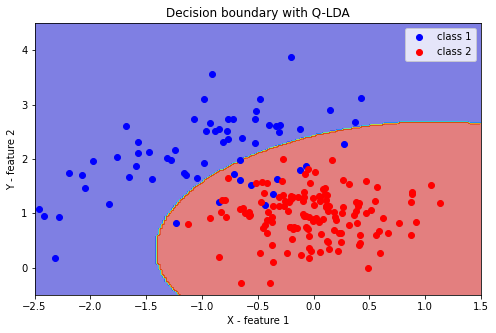

In [34]:
feature1_square_to_be_added = xy[:,0]**2
feature2_square_to_be_added = xy[:,1]**2
feature1_multiply_feature2_to_be_added = xy[:,0]*xy[:,1]
xy_5 = np.hstack((xy, 
                       np.atleast_2d(feature1_square_to_be_added).T, # add feature1 square
                       np.atleast_2d(feature2_square_to_be_added).T, # add feature2 square
                       np.atleast_2d(feature1_multiply_feature2_to_be_added).T)) # add feature1 * feature2
class_L = []
for item in xy_5:
        class_L.append(pred(y_QLDA_1(item), y_QLDA_2(item)))
class_L = np.array(class_L).reshape(test.shape[0], test.shape[0])
visualize(class_L, model_name="Q-LDA")

the decision boudary projected on 2D is similar to the previous on with QDA model and slightly more convex. 

In [35]:
prediction_train = np.array([pred(y_QLDA_1(item), y_QLDA_2(item)) for item in new_train[:, 1:]])
prediction_test = np.array([pred(y_QLDA_1(item), y_QLDA_2(item)) for item in new_test[:, 1:]])
print("train error: ", error(prediction_train, train[:, 0]))
print("test error: ", error(prediction_test, test[:, 0]))

train error:  0.05
test error:  0.055


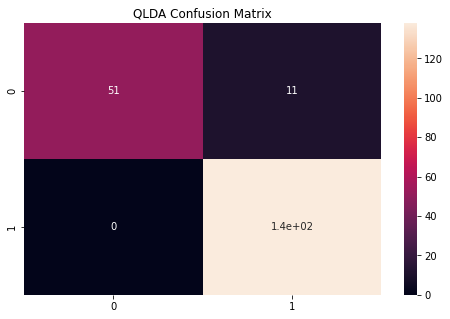

In [36]:
cm = confusion_matrix(test[:, 0], prediction_test)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(8, 5), facecolor='white')
plt.title("QLDA Confusion Matrix")
sns.heatmap(cm, annot=True, cbar=False)
plt.show()

In [37]:
accuracy_QLDA = (tp + tn) / (tp + tn + fp + fn)
precision_QLDA = tp / (tp + fp)
recall_QLDA = tp / (tp + fn)
F1_QLDA = 2 * (precision_QLDA * recall_QLDA) / (precision_QLDA + recall_QLDA)
mcc_QLDA = (tp*tn - fp*fn)/ sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(f"The accuracy of QLDA = {round(accuracy_QLDA, 4)}")
print(f"The precision of QLDA = {round(precision_QLDA, 4)}")
print(f"The recall of QLDA = {round(recall_QLDA, 4)}")
print(f"The F1 of QLDA = {round(F1_QLDA, 4)}")
print(f"The MCC score of QLDA = {round(mcc_QLDA, 4)}")

The accuracy of QLDA = 0.945
The precision of QLDA = 0.9262
The recall of QLDA = 1.0
The F1 of QLDA = 0.9617
The MCC score of QLDA = 0.8728


The perfomance of the LDA on the quadratic representation is worse than the previous model on the class 1 but is the best on class 2. If we kept the recall as metric we wouldn't have seen this difference, so choosing multiple metrics allow to understand better the behaviour of the model on different classes.

In [38]:
# store all metrics in a dict
metrics["QLDA"] = {"Accuracy" : accuracy_QLDA, "precision": precision_QLDA, "recall": recall_QLDA, "F1": F1_QLDA, "MCC": mcc_QLDA}

## Compare the three DA methods

In [39]:
df = pd.DataFrame.from_dict(metrics)
df.round(3)

,LDA,QDA,QLDA
Accuracy,0.945,0.950,0.945
precision,0.932,0.938,0.926
recall,0.993,0.993,1.000
F1,0.961,0.965,0.962
MCC,0.871,0.883,0.873


The QDA model performs best on the test set with regards to all the metrics implemented, except for the recall with QLDA scores 100%. From the confusion matrix, it is clear that QDA classifies well all the positive class (class 2), but it has the most trouble classifying instances in class 1. There isn't a big different between the models, although it is interesting to see that QLDA performs similarly to LDA than QDA even if the decision boundary is similar to QDA's.

### Different representations with LDA
We have tried to add quadratic features and applied LDA on this representation, but we can try other representations of the data $\Phi(X)$. We have two features, so going beyond a polynomial of second degree would linkely lead to an overfitting. Also, in our case applying a non-linear representation wouldn't benefit us greatly as we've seen in our data distribution plot.

## Compare with KNN

We implement a KNN model with sklearn. We pply a grid search cross validation on the number of neighbors, the cross validation is stratified given our imbalanced data.

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
results_knn = []
params ={"n_neighbors": arange(1, 20)}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid=params, cv=3)
grid.fit(train[:, 1:], train[:, 0])
print(grid.best_params_)

{'n_neighbors': 6}


When applying this grid search, we notice the the  number of folds influences the best parameter we get. For cv=5, we only have 10 instances of class 1 per fold, so it makes sense the best number of neighbors is lower than the one we get from cv=3. Since we don't have a large data set we kept cv=3 in order to give the model enough data for testing.

In [41]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(train[:, 1:], train[:, 0])
print("train error: ", round(1 - knn.score(train[:, 1:], train[:, 0]), 4))
print("test error: ", round(1 - knn.score(test[:, 1:], test[:, 0]), 4))

train error:  0.03
test error:  0.055


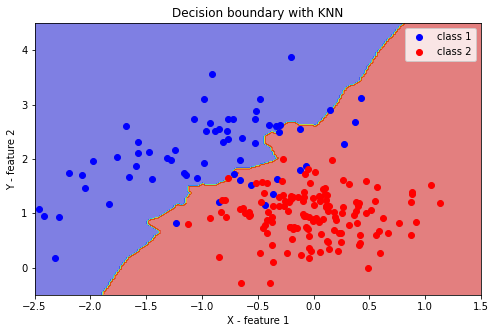

In [42]:
f1 = lambda x: knn.predict_proba(x)[0][0]
f2 = lambda x: knn.predict_proba(x)[0][1]
class_L = []
for item in xy:
    class_L.append(pred(f1(item.reshape(1, 2)), f2(item.reshape(1, 2))))
class_L = np.array(class_L).reshape(test.shape[0], test.shape[0])
visualize(class_L, model_name="KNN")

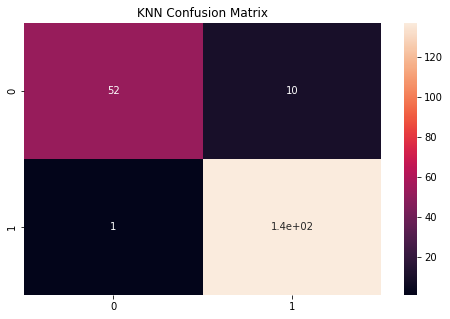

In [43]:
prediction_test = knn.predict(test[:, 1:])
cm = confusion_matrix(test[:, 0], prediction_test)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(8, 5), facecolor='white')
plt.title("KNN Confusion Matrix")
sns.heatmap(cm, annot=True, cbar=False)
plt.show()

Fron the confusion matrix, we can conclude that the KNN model we chose will perform worse than the QDA on the class 1, but similarly to QLDA on class 2. Indeed, when we plot the data distribution, we note that the elements in the separation line are mostly from class 2 (imbalance). In this situation the KNN applied to the elements from class 1 would fail (as most their neighbors are from the class 2). 

## TO DO : LDA & QDA using scikit-learn module

The module `scikit-learn` is dedicated to machine learning algorithms. Many of them are available in a simple manner. For LDA and QDA, have a look at the tutorial available at http://scikit-learn.org/stable/modules/lda_qda.html 

**Warning** : you may have a critical view of the way LDA and QDA are illustrated in the proposed example...




In [44]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver = "lsqr") # similar to our implementation
lda.fit(train[:, 1:], train[:, 0])
print("train error: ", round(1 - lda.score(train[:, 1:], train[:, 0]), 4))
print("test error: ", round(1 - lda.score(test[:, 1:], test[:, 0]), 4))

train error:  0.03
test error:  0.055


In [45]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(train[:, 1:], train[:, 0])
print("train error: ", round(1 - qda.score(train[:, 1:], train[:, 0]), 4))
print("test error: ", round(1 - qda.score(test[:, 1:], test[:, 0]), 4))

train error:  0.05
test error:  0.05


We get the same results as the models from the first parts. Sci-Kit learn actually implements more methods for these two objects such as the shrinkage, a regularization method for cases where the number of samples is lower than that of the features (likely to be overfitting). A regularization can also be applied to QDA: S1 becomes $$ S1 = (1 - \lambda)*S_1 +\lambda*I_n$$ The sklearn module centers the data from each class and apply a singular value decomposition on the covariance matrices to get the diagonal matrices $S_1$, $S_2$ 

In their example, a varying covariance can not be applied on the LDA as its main hypothetis is that the convariance matrices of the two classes in the same. So in the case where it's not, we can clearly see for the plot that the model is failing.

## Cross-Validation
In order to get a better perspective of the performance, we'll apply a stratified cross validation on 3 folds as we don't have a large data set.

In [46]:
from sklearn.model_selection import StratifiedKFold, cross_validate
np.random.seed(10)
results_lda = cross_validate(lda, train[:, 1:], train[:, 0], cv=StratifiedKFold(n_splits=3, shuffle=True))
results_qda = cross_validate(qda, train[:, 1:], train[:, 0], cv=StratifiedKFold(n_splits=3, shuffle=True))
print(f"For LDA: mean {mean(results_lda['test_score'])} and std of {round(std(results_lda['test_score']), 3)}")
print(f"For QDA: mean {mean(results_qda['test_score'])} and std of {round(std(results_qda['test_score']), 3)}")

For LDA: mean 0.9402852049910874 and std of 0.024
For QDA: mean 0.9503862150920974 and std of 0.037


The results from the cross validation are not varying a lot which confirms our findings.

## Towards Support Vector Machines

Following the previous part, we'll explore how another model changes the data representation to distinguish better the classes. While many more complex model apply this transformation, a typical deep learning for instance would encode the data into an N-dimensional vector before predicting the class. These models would be difficult to visualize and interpret (if not approximated to a linear model with LIME [1]).

We'll be using supper vector machine. Given that we have two continuous features, it will be easier to plot the decision boundaries.

The model were kept in their default parameters, the polynomial kernel was set to 2 degrees as we only have two features.
The following code to visualize the decision boundaries was extracted from the documentation [2]

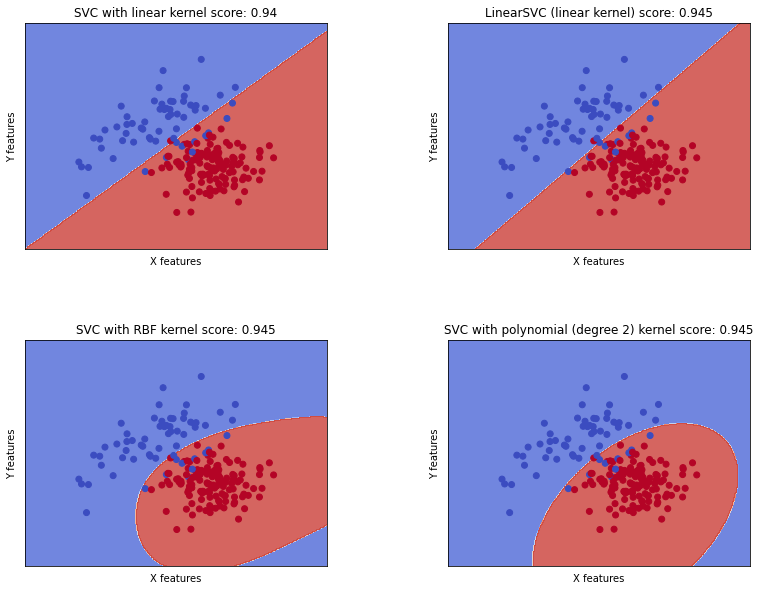

In [47]:
from sklearn import svm
svc = svm.SVC(kernel='linear').fit(train[:, 1:], train[:, 0])
rbf_svc = svm.SVC(kernel='rbf').fit(train[:, 1:], train[:, 0])
poly_svc = svm.SVC(kernel='poly', degree=2).fit(train[:, 1:], train[:, 0])
lin_svc = svm.LinearSVC().fit(train[:, 1:], train[:, 0])
h = .02  # step size in the mesh

# create a mesh to plot in
x_min, x_max = test[:, 1].min() - 1, test[:, 1].max() + 1
y_min, y_max = test[:, 2].min() - 1, test[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = [f'SVC with linear kernel score: {svc.score(test[:, 1:], test[:, 0])}',
          f'LinearSVC (linear kernel) score: {lin_svc.score(test[:, 1:], test[:, 0])}',
          f'SVC with RBF kernel score: {rbf_svc.score(test[:, 1:], test[:, 0])}',
          f'SVC with polynomial (degree 2) kernel score: {poly_svc.score(test[:, 1:], test[:, 0])}']

plt.figure(figsize=(13, 10), facecolor='white')
for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(test[:, 1], test[:, 2], c=test[:, 0], cmap=plt.cm.coolwarm)
    plt.xlabel('X features')
    plt.ylabel('Y features')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

It is difficult to compare the SVM models and the LDA/QDA from a decision process perspective, so we will attempt to understand the decision boundaries of each one of them:

The SVM models performed similarly and worse on the class 1 than our QDA model. The Linear SVM and LDA have the same predictions since we don't have many points next to the separation line (the support vectors). The LinearSVM and SVC with linear kernel are similar, the difference [3] is that the LinearSVM has more choices for the loss function (here square hinge) compared to the second (loss = hinge).

The QDA gave better predictions than the polynomial kernel of second degree. This might be due to the fact that the former makes use of all the data whereas the latter focuses on a subset.

The RBF is not easy to interpret as the dimension of the latent space can be infinite, here our regularization parameter C was set to the default value (1.0), but we could try lower values.

__Conclusion__
Our data seems a first glance to be linearly separable, except for few points in the intersection. When plotting the probability plot, we concluded that the features were indeed normally distributed, but their respective estimated covariance matrices were not the same. The conditions for QDA were met and it had the best performance of the two. We also tried increasing the dimensionality of the problem by adding quadratic representations then applying LDA to highlight the distinctions of the classes, but it did not yield to better results. 

We compared our best model to two other classification models: KNN and SVM. The KNN failed on the minority class. The SVM was proposed as it uses the kernel trick to find a good representation of the data, then finds a hyperplane to separate the support vectors. We expected to have a better performance, especially when the SVM focuses on points that are not easy to separate, but it turned out to have a worse performance than QDA (that makes use of all the data). This experiment could be revised after the SVM models are finetuned.

[1]: M. T. Ribeiro, S. Singh, C. Guestrin, ”why should i trust you?”: Explaining the predictions of any classifier (2016).
doi:10.48550/ARXIV.1602.04938.
URL https://arxiv.org/abs/1602.04938

[2] https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html

[3] https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

[4] https://fr.wikipedia.org/wiki/R%C3%A8gle_de_Sturges

In [52]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [53]:
import os

os.system('jupyter nbconvert --to html TP2_MAKHLOUF_MAKNI.ipynb')

0